# Changing climate w/ White Noise Processes
Vary the forcings with white noise around a fixed mean (static climate, stochastic variability) to make a dynamic model

In [1]:
import firedrake
from firedrake import min_value, max_value
import icepack
import icepack.plot
import tqdm
import numpy as np
from firedrake import interpolate
import matplotlib.pyplot as plt

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


# Initial Conditions and geom.

In [2]:
Lx, Ly = 50e3, 12e3
nx, ny = 48, 32

mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)

Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)

In [31]:
x, y = firedrake.SpatialCoordinate(mesh)

b_in, b_out = 3000, 0
δb1, δb2 = 0.1, -8*10**-7
δby = 500

b_expr = b_in - (δb1*x) - (δb2*x**2) - 4 * δby * (y/Ly)*(1 - y/Ly)
#b_expr = b_in -0.1*x + (8*10**-7)*x**2

b = firedrake.interpolate(b_expr, Q)

s_in, s_out = 3000, 0 
s_expr = s_in - (s_in - s_out) * x / Lx 
s0 = firedrake.interpolate(s_expr, Q)

h0 = firedrake.interpolate(s0 - b, Q)

In [32]:
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
)

h_in = s_in - b_in
δs_δx = (s_out - s_in) / Lx
δb_δx = (b_out - b_in) / Lx

τ_D = -ρ_I * g * h_in * δs_δx
print(f"{1000 * τ_D} kPa")
print(δs_δx)

0.0 kPa
-0.06


In [33]:
u_in, u_out = 800, 10 # Is this inflow and term. velocities?
velocity_x = u_in + (u_out - u_in) * (x / Lx) ** 2

In [34]:
T = firedrake.Constant(273.15) # Is this where I can mess aorund with warming and cooling functions?
A = icepack.rate_factor(T) #Glen flow coef. based on set T (e = A*tau^n)

In [35]:
model = icepack.models.ShallowIce()
solver = icepack.solvers.FlowSolver(model)

In [36]:
u0 = firedrake.interpolate(firedrake.as_vector((velocity_x, 0)), V)
h = h0.copy(deepcopy=True)
u = solver.diagnostic_solve( #First guess at vel. using the diagnostic solver
    velocity=u0, 
    thickness=h, 
    surface=s0, 
    fluidity=A,
)

Text(0, 0.5, 'Width (m)')

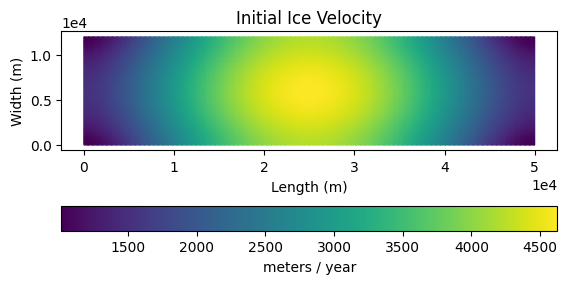

In [37]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u, axes=axes)
fig.colorbar(colors, label="meters / year", location='bottom')
axes.set_title("Initial Ice Velocity");
axes.set_xlabel("Length (m)")
axes.set_ylabel("Width (m)")

Text(0, 0.5, 'elevation (m)')

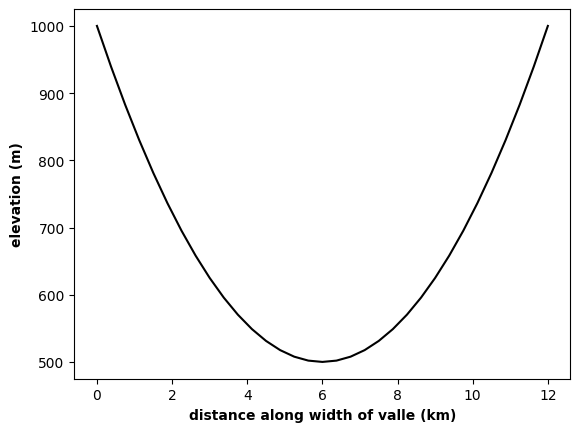

In [45]:
ys = np.array([(Lx/2, Ly * k / ny) for k in range(ny + 1)])
by = np.array(b.at(ys, tolerance=1e-10))

fig, axes = plt.subplots()
axes.plot(ys[:,1] / 1e3, by, color="black", label = "Bed")
axes.set_xlabel("distance along width of valle (km)", fontweight = 'bold')
axes.set_ylabel("elevation (m)", fontweight = 'bold')

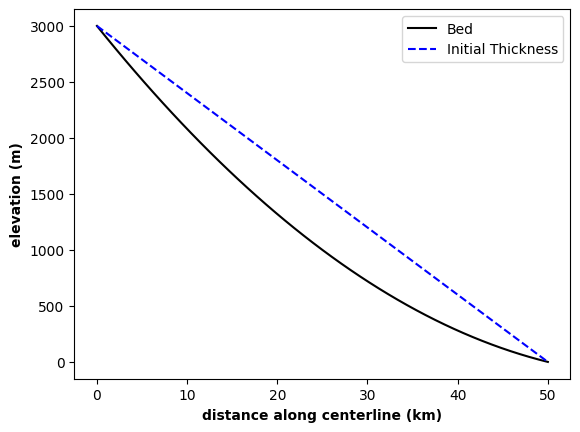

In [46]:
xs = np.array([(Lx * k / nx, 0) for k in range(nx + 1)])

h0s = np.array(h0.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))

fig, axes = plt.subplots()
axes.plot(xs[:, 0] / 1e3, bs, color="black", label = "Bed")
axes.plot(xs[:, 0] / 1e3, h0s + bs, linestyle = 'dashed', color="blue", label = "Initial Thickness")
axes.set_xlabel("distance along centerline (km)", fontweight = 'bold')
axes.set_ylabel("elevation (m)", fontweight = 'bold')
axes.legend()

# Modelling!
## Mass Balance Inputs
Using different ways of approximating MB. Dan's initial way utilized lapse rates and ELA. In this model, these inputs all have rapid fluctutations around a steady mean. My PDD model uses that funct. as an initial guess and then calculates surface lowering based off it. Next is a surface energy balance model.

In [10]:
dt = 0.25
num_timesteps = 80

def mass_balance(s, max_a=0.5, da_ds=0.5/1000, ela=0.0): 
    return min_value((s - ela) * da_ds, max_a)

ela = 600. 
ela_std = 200.
ela_noise = np.random.normal(0, ela_std, size=num_timesteps)

max_a = 1
maxa_std = 0.2
maxa_noise = np.random.normal(0, maxa_std, size=num_timesteps)

da_ds = 0.5/1000 #Tweak these, need to ensure ELA and accum. are ok match w/ temp. Can use inverse approach?
dads_std = 0.01/1000
dads_noise = np.random.normal(0, dads_std, size=num_timesteps)

In [11]:
temp_cyc = list([266.5, 273.15, 289.8, 273.15]) #Wi-Sp-Su-Fa
temp_list = temp_cyc * int(num_timesteps/len(temp_cyc))

a0 = mass_balance(s0, ela=ela, max_a=max_a, da_ds=da_ds)
def PDD_model(temp_list, k_i, k_s, a0, dt): #PDD via avg szn temperature, even days b/t months for simplicity (Johannesson and others, 95)
    PDD = 0
    dt_count = 0
    for i in range(num_timesteps):
        if dt_count * dt < 1:
            if temp_list[i] >= 273.15:
                temp_0 = temp_list[i] - 273.15
                PDD += 90 * temp_0
                dt_count += 1
            else:
                PDD+=0
                dt_count += 1
        elif dt_count * dt == 1:
            PDD = 0
            dt_count =0
   # m = (k_i*PDD + k_s*PDD)*1000
    m = (k_s*PDD)
    return(a0 - m)

In [12]:
dh_max = np.zeros(num_timesteps) * np.nan
a = mass_balance(s0, ela=ela, max_a=max_a, da_ds=da_ds)

for step in tqdm.trange(num_timesteps):
    
    a = interpolate(a, Q)
    
    h_old = h.copy(deepcopy=True)
    h = solver.prognostic_solve(
        dt,
        thickness=h,
        accumulation=a,
        velocity=u,
    )
    
    h.interpolate(max_value(h, 0)) 
    s = interpolate(h + b, Q)
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        surface=s,
        fluidity=A,
    )
    a = PDD_model(temp_list, .04, .6, a, dt)
    #a = mass_balance(s, ela=ela+ela_noise[step], max_a=max_a+maxa_noise[step], da_ds=da_ds+dads_noise[step])
    dh = interpolate(h - h_old, Q)
    
    dh_max[step] = dh.dat.data_ro.max()

100%|███████████████████████████████████████████| 80/80 [00:47<00:00,  1.67it/s]


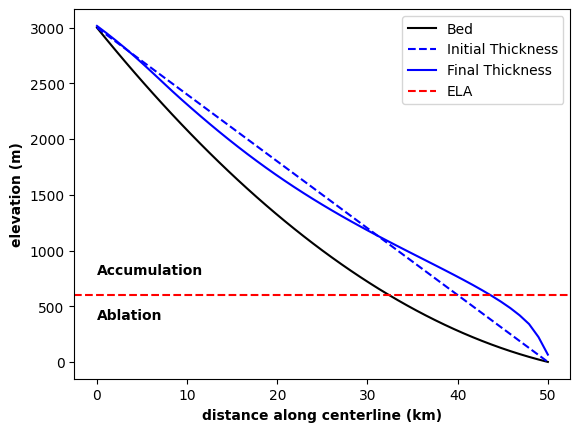

In [13]:
xs = np.array([(Lx * k / nx, 0) for k in range(nx + 1)])

ss = np.array(s.at(xs, tolerance=1e-10))
h0s = np.array(h0.at(xs, tolerance=1e-10))
hs = np.array(h.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))

fig, axes = plt.subplots()
axes.plot(xs[:, 0] / 1e3, bs, color="black", label = "Bed")
axes.plot(xs[:, 0] / 1e3, h0s + bs, linestyle = 'dashed', color="blue", label = "Initial Thickness")
axes.plot(xs[:, 0] / 1e3, hs + bs, color="blue", label = "Final Thickness")
axes.axhline(y = ela, color = 'r', linestyle = 'dashed', label = "ELA")
axes.set_xlabel("distance along centerline (km)", fontweight = 'bold')
axes.text(0, ela + 190, 'Accumulation', fontweight = 'bold')
axes.text(0, ela - 220, 'Ablation', fontweight = 'bold')
axes.set_ylabel("elevation (m)", fontweight = 'bold')
axes.legend()

Text(0, 0.5, 'Width (m)')

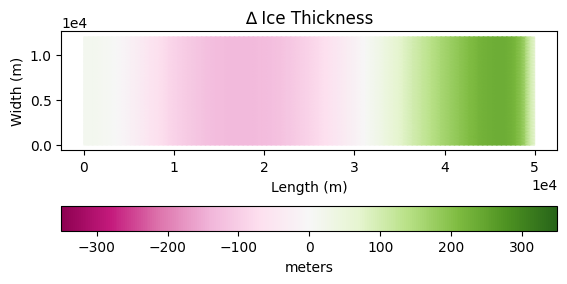

In [14]:
fig, axes = icepack.plot.subplots()
thickness_change = interpolate(h - h0, Q)
colors = icepack.plot.tripcolor(
    thickness_change, 
    vmin=-350, vmax=350, 
    axes=axes, cmap="PiYG"
)
fig.colorbar(colors, label="meters", location='bottom')
axes.set_title("∆ Ice Thickness");
axes.set_xlabel("Length (m)")
axes.set_ylabel("Width (m)")

Text(0, 0.5, 'Width (m)')

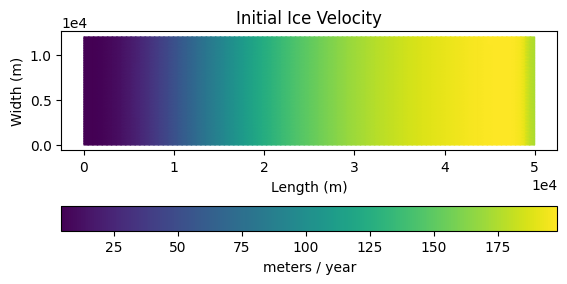

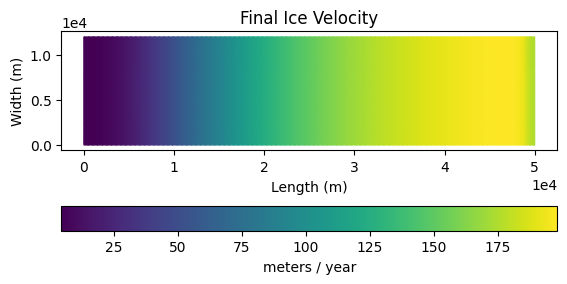

In [15]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u, axes=axes)
fig.colorbar(colors, label="meters / year", location='bottom')
axes.set_title("Initial Ice Velocity");
axes.set_xlabel("Length (m)")
axes.set_ylabel("Width (m)")

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u, axes=axes)

fig.colorbar(colors, label="meters / year", location='bottom')
axes.set_title("Final Ice Velocity");
axes.set_xlabel("Length (m)")
axes.set_ylabel("Width (m)")

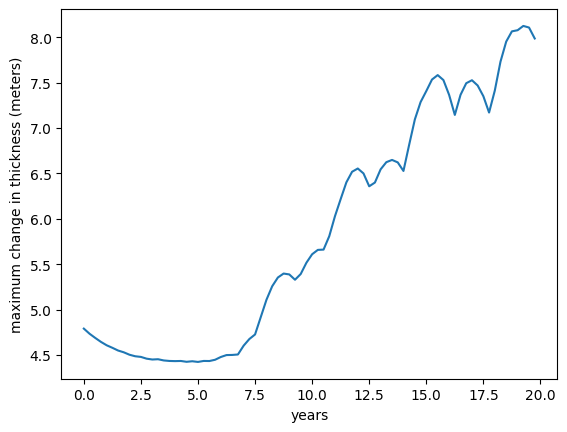

In [16]:
plt.figure()
plt.plot(dt * np.arange(num_timesteps), dh_max)
plt.xlabel("years")
plt.ylabel("maximum change in thickness (meters)")
axes.set_title("Max Change in Ice Thickness at each Time Step");